# Train a Hypergraph Networks with Hyperedge Neurons (HNHN)

In this notebook, we will create and train a Hypergraph Networks with Hyperedge Neurons in the hypergraph domain, as proposed in the paper by [Dong et al. : HNHN: Hypergraph networks with hyperedge neurons (2020)](https://grlplus.github.io/papers/40.pdf). 

We train the model to perform binary node classification using the KarateClub benchmark dataset. 

The equations of one layer of this neural network are given by:

🟥 $\quad m_{y \rightarrow x}^{(0 \rightarrow 1)} = \sigma((B_1^T \cdot W^{(0)})_{xy} \cdot h_y^{t,(0)} \cdot \Theta^{t,(0)} + b^{t,(0)})$ 

🟥 $\quad m_{y \rightarrow x}^{(1 \rightarrow 0)}  = \sigma((B_1 \cdot W^{(1)})_{xy} \cdot h_y^{t,(1)} \cdot \Theta^{t,(1)} + b^{t,(1)})$ 

🟧 $\quad m_x^{(0 \rightarrow 1)}  = \sum_{y \in \mathcal{B}(x)} m_{y \rightarrow x}^{(0 \rightarrow 1)}$ 

🟧 $\quad m_x^{(1 \rightarrow 0)}  = \sum_{y \in \mathcal{C}(x)} m_{y \rightarrow x}^{(1 \rightarrow 0)}$ 

🟩 $\quad m_x^{(0)}  = m_x^{(1 \rightarrow 0)}$ 

🟩 $\quad m_x^{(1)}  = m_x^{(0 \rightarrow 1)}$ 

🟦 $\quad h_x^{t+1,(0)}  = m_x^{(0)}$ 

🟦 $\quad h_x^{t+1,(1)} = m_x^{(1)}$


Where the notations are defined in [Papillon et al : Architectures of Topological Deep Learning: A Survey of Topological Neural Networks (2023)](https://arxiv.org/abs/2304.10031).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import toponetx.datasets.graph as graph
from topomodelx.nn.hypergraph.hnhn_layer import HNHNLayer
import matplotlib.pyplot as plt
from topomodelx.nn.hypergraph.hnhn import HNHN

If there is an available GPU, we will use it. Otherwise, this will run on CPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Pre-processing

## Import dataset ##

The first step is to import the Karate Club (https://www.jstor.org/stable/3629752) dataset. This is a singular graph with 34 nodes that belong to two different social groups. We will use these groups for the task of node-level binary classification.

We must first lift our graph dataset into the hypergraph domain.

In [3]:
dataset_sim = graph.karate_club(complex_type="simplicial")
dataset_hyp = dataset_sim.to_hypergraph()

## Define neighborhood structures. ##

Now we retrieve the neighborhood structures (i.e., their representative matrices) that we will use to send messages on the domain. In this case, we need the boundary matrix (or incidence matrix) $B_1$. For a santiy check, we show that the shape of the $B_1 = n_\text{nodes} \times n_\text{edges}$. We also convert the neighborhood structures to sparse torch tensors.

In [4]:
incidence_1 = dataset_sim.incidence_matrix(rank=1, signed=False)
incidence_1 = torch.from_numpy(incidence_1.todense()).to_sparse()
print(f"The incidence matrix B1 has shape: {incidence_1.shape}.")

The incidence matrix B1 has shape: torch.Size([34, 78]).


## Import signal ##
Our task will be node classification. To classify the nodes, we will use:
- node features $X_0$; shape: $n_{nodes} \times channels_{node}$
- edge features $X_1$; shape: $n_{edges} \times channels_{edge}$

For the this specific dataset, we have $channels_{node}$ = $channels_{edge}$ = 2.
Next, we will retrieve node features, edge features, and node labels $y$. The node labels will be one-hot encoded.

In [5]:
# Node features
x_0 = []
for _, v in dataset_sim.get_simplex_attributes("node_feat").items():
    x_0.append(v)
x_0 = torch.tensor(np.stack(x_0)).to(device)
n_nodes, channels_node = x_0.shape
print(f"There are {n_nodes} nodes with features of dimension {channels_node}.")

There are 34 nodes with features of dimension 2.


In [6]:
# Edge features
x_1 = []
for k, v in dataset_sim.get_simplex_attributes("edge_feat").items():
    x_1.append(v)
x_1 = torch.tensor(np.stack(x_1)).to(device)
n_edges, channels_edge = x_1.shape
print(f"There are {n_edges} edges with features of dimension {channels_edge}.")

There are 78 edges with features of dimension 2.


In [7]:
# Node labels
y = np.array(
    [
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        0,
        1,
        1,
        1,
        1,
        0,
        0,
        1,
        1,
        0,
        1,
        0,
        1,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
    ]
)
n_classes = len(np.unique(y))
y_1h = np.eye(n_classes)[y].astype(int)  # 1-hot representation
print(f"There are {y_1h.shape[0]} labels, one for each node.")

There are 34 labels, one for each node.


We will now split the dataset into stratified training (85%) and test sets (15%)

In [8]:
y_train, y_test, ind_train, ind_test = train_test_split(
    y_1h, np.arange(n_nodes), test_size=0.15, random_state=0, stratify=y
)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.int32).to(device)
print(
    f"Fraction of class-1 samples in the training set: {torch.sum(y_train[:,0])/y_train.shape[0]}"
)
print(
    f"Fraction of class-1 samples in the test set: {torch.sum(y_test[:,0])/y_test.shape[0]}"
)

Fraction of class-1 samples in the training set: 0.5
Fraction of class-1 samples in the test set: 0.5


# Create the Neural Network

Using the HNHNLayer class, we define a neural network for node classification.

In [21]:
class HNHNNetwork(torch.nn.Module):
    """Hypergraph Networks with Hyperedge Neurons. Implementation for multiclass node classification.

    Parameters
    ---------
    channels_node : int
        Dimension of node features.
    channels_edge : int
        Dimension of edge features.
    incidence_1 : torch.sparse
        Incidence matrix mapping edges to nodes (B_1).
        shape=[n_nodes, n_edges]
    n_classes: int
        Number of classes
    n_layers : int
        Number of HNHN message passing layers.
    """

    def __init__(
        self, channels_node, channels_edge, incidence_1, n_classes, n_layers=2
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList(
            [
                HNHNLayer(
                    channels_node=channels_node,
                    channels_edge=channels_edge,
                    incidence_1=incidence_1,
                )
                for _ in range(n_layers)
            ]
        )
        self.linear = torch.nn.Linear(channels_node, n_classes)

    def forward(self, x_0, x_1):
        """Forward computation.

        Parameters
        ---------
        x_0 : torch.Tensor
            shape = [n_nodes, channels_node]
            Hypernode features.

        x_1 : torch.Tensor
            shape = [n_nodes, channels_edge]
            Hyperedge features.

        incidence_1 : tensor
            shape = [n_nodes, n_edges]
            Boundary matrix of rank 1.

        Returns
        --------
        logits : torch.Tensor
            The predicted node logits
            shape = [n_nodes, n_classes]
        classes : torch.Tensor
            The predicted node class
            shape = [n_nodes]
        """
        for layer in self.layers:
            x_0, x_1 = layer(x_0, x_1)
        logits = self.linear(x_0)
        classes = torch.softmax(logits, -1).argmax(-1)
        return logits, classes

# Train the Neural Network

We initialize the HNHNNetwork model with our pre-made neighborhood structures and specify an optimizer and a suitable loss.

In [9]:
model = HNHN(
    channels_node=channels_node,
    channels_edge=channels_edge,
    incidence_1=incidence_1,
    n_classes=n_classes,
    n_layers=2,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.5 * 1e-2)
criterion = torch.nn.CrossEntropyLoss()

Next, we train the model for 2000 epochs.

In [10]:
test_interval = 20
num_epochs = 2000
get_accuracy = lambda yhat, ytrue: (yhat == ytrue).float().mean()
losses = np.full((num_epochs), np.nan)
train_accs = np.full((num_epochs), np.nan)
test_accs = np.full((num_epochs), np.nan)
for epoch_i in range(num_epochs):
    # Train model
    model.train()
    optimizer.zero_grad()
    y_hat, y_hat_cls = model(x_0, x_1)
    loss = criterion(y_hat[ind_train], y_train)
    loss.backward()
    optimizer.step()
    train_acc = get_accuracy(y_hat_cls[ind_train], y[ind_train])
    print(
        f"Epoch: {epoch_i}-------- \nLoss: {loss.item():.4f} \nTrain_acc: {train_acc.item():.4f}",
        flush=True,
    )
    # Evaluate model
    if epoch_i % test_interval == 0 or epoch_i == num_epochs - 1:
        with torch.no_grad():
            y_hat, y_hat_cls = model(x_0, x_1)
            test_acc = get_accuracy(y_hat_cls[ind_test], y[ind_test])
            print(f"Test_acc: {test_acc.item():.4f}", flush=True)
            test_accs[epoch_i] = test_acc.item()

    # Store metrics
    losses[epoch_i] = loss.item()
    train_accs[epoch_i] = train_acc.item()

Epoch: 0-------- 
Loss: 0.6981 
Train_acc: 0.5000
Test_acc: 0.5000
Epoch: 1-------- 
Loss: 0.6971 
Train_acc: 0.5000
Epoch: 2-------- 
Loss: 0.6963 
Train_acc: 0.5000
Epoch: 3-------- 
Loss: 0.6957 
Train_acc: 0.5000
Epoch: 4-------- 
Loss: 0.6951 
Train_acc: 0.5000
Epoch: 5-------- 
Loss: 0.6946 
Train_acc: 0.5000
Epoch: 6-------- 
Loss: 0.6942 
Train_acc: 0.5000
Epoch: 7-------- 
Loss: 0.6939 
Train_acc: 0.5000
Epoch: 8-------- 
Loss: 0.6938 
Train_acc: 0.5000
Epoch: 9-------- 
Loss: 0.6936 
Train_acc: 0.5000
Epoch: 10-------- 
Loss: 0.6936 
Train_acc: 0.5000
Epoch: 11-------- 
Loss: 0.6936 
Train_acc: 0.5000
Epoch: 12-------- 
Loss: 0.6936 
Train_acc: 0.5000
Epoch: 13-------- 
Loss: 0.6937 
Train_acc: 0.5000
Epoch: 14-------- 
Loss: 0.6937 
Train_acc: 0.5000
Epoch: 15-------- 
Loss: 0.6938 
Train_acc: 0.5000
Epoch: 16-------- 
Loss: 0.6938 
Train_acc: 0.5000
Epoch: 17-------- 
Loss: 0.6938 
Train_acc: 0.5000
Epoch: 18-------- 
Loss: 0.6939 
Train_acc: 0.5000
Epoch: 19-------- 
Loss:

Finally, we plot the training results

Text(0.5, 1.0, 'Training results')

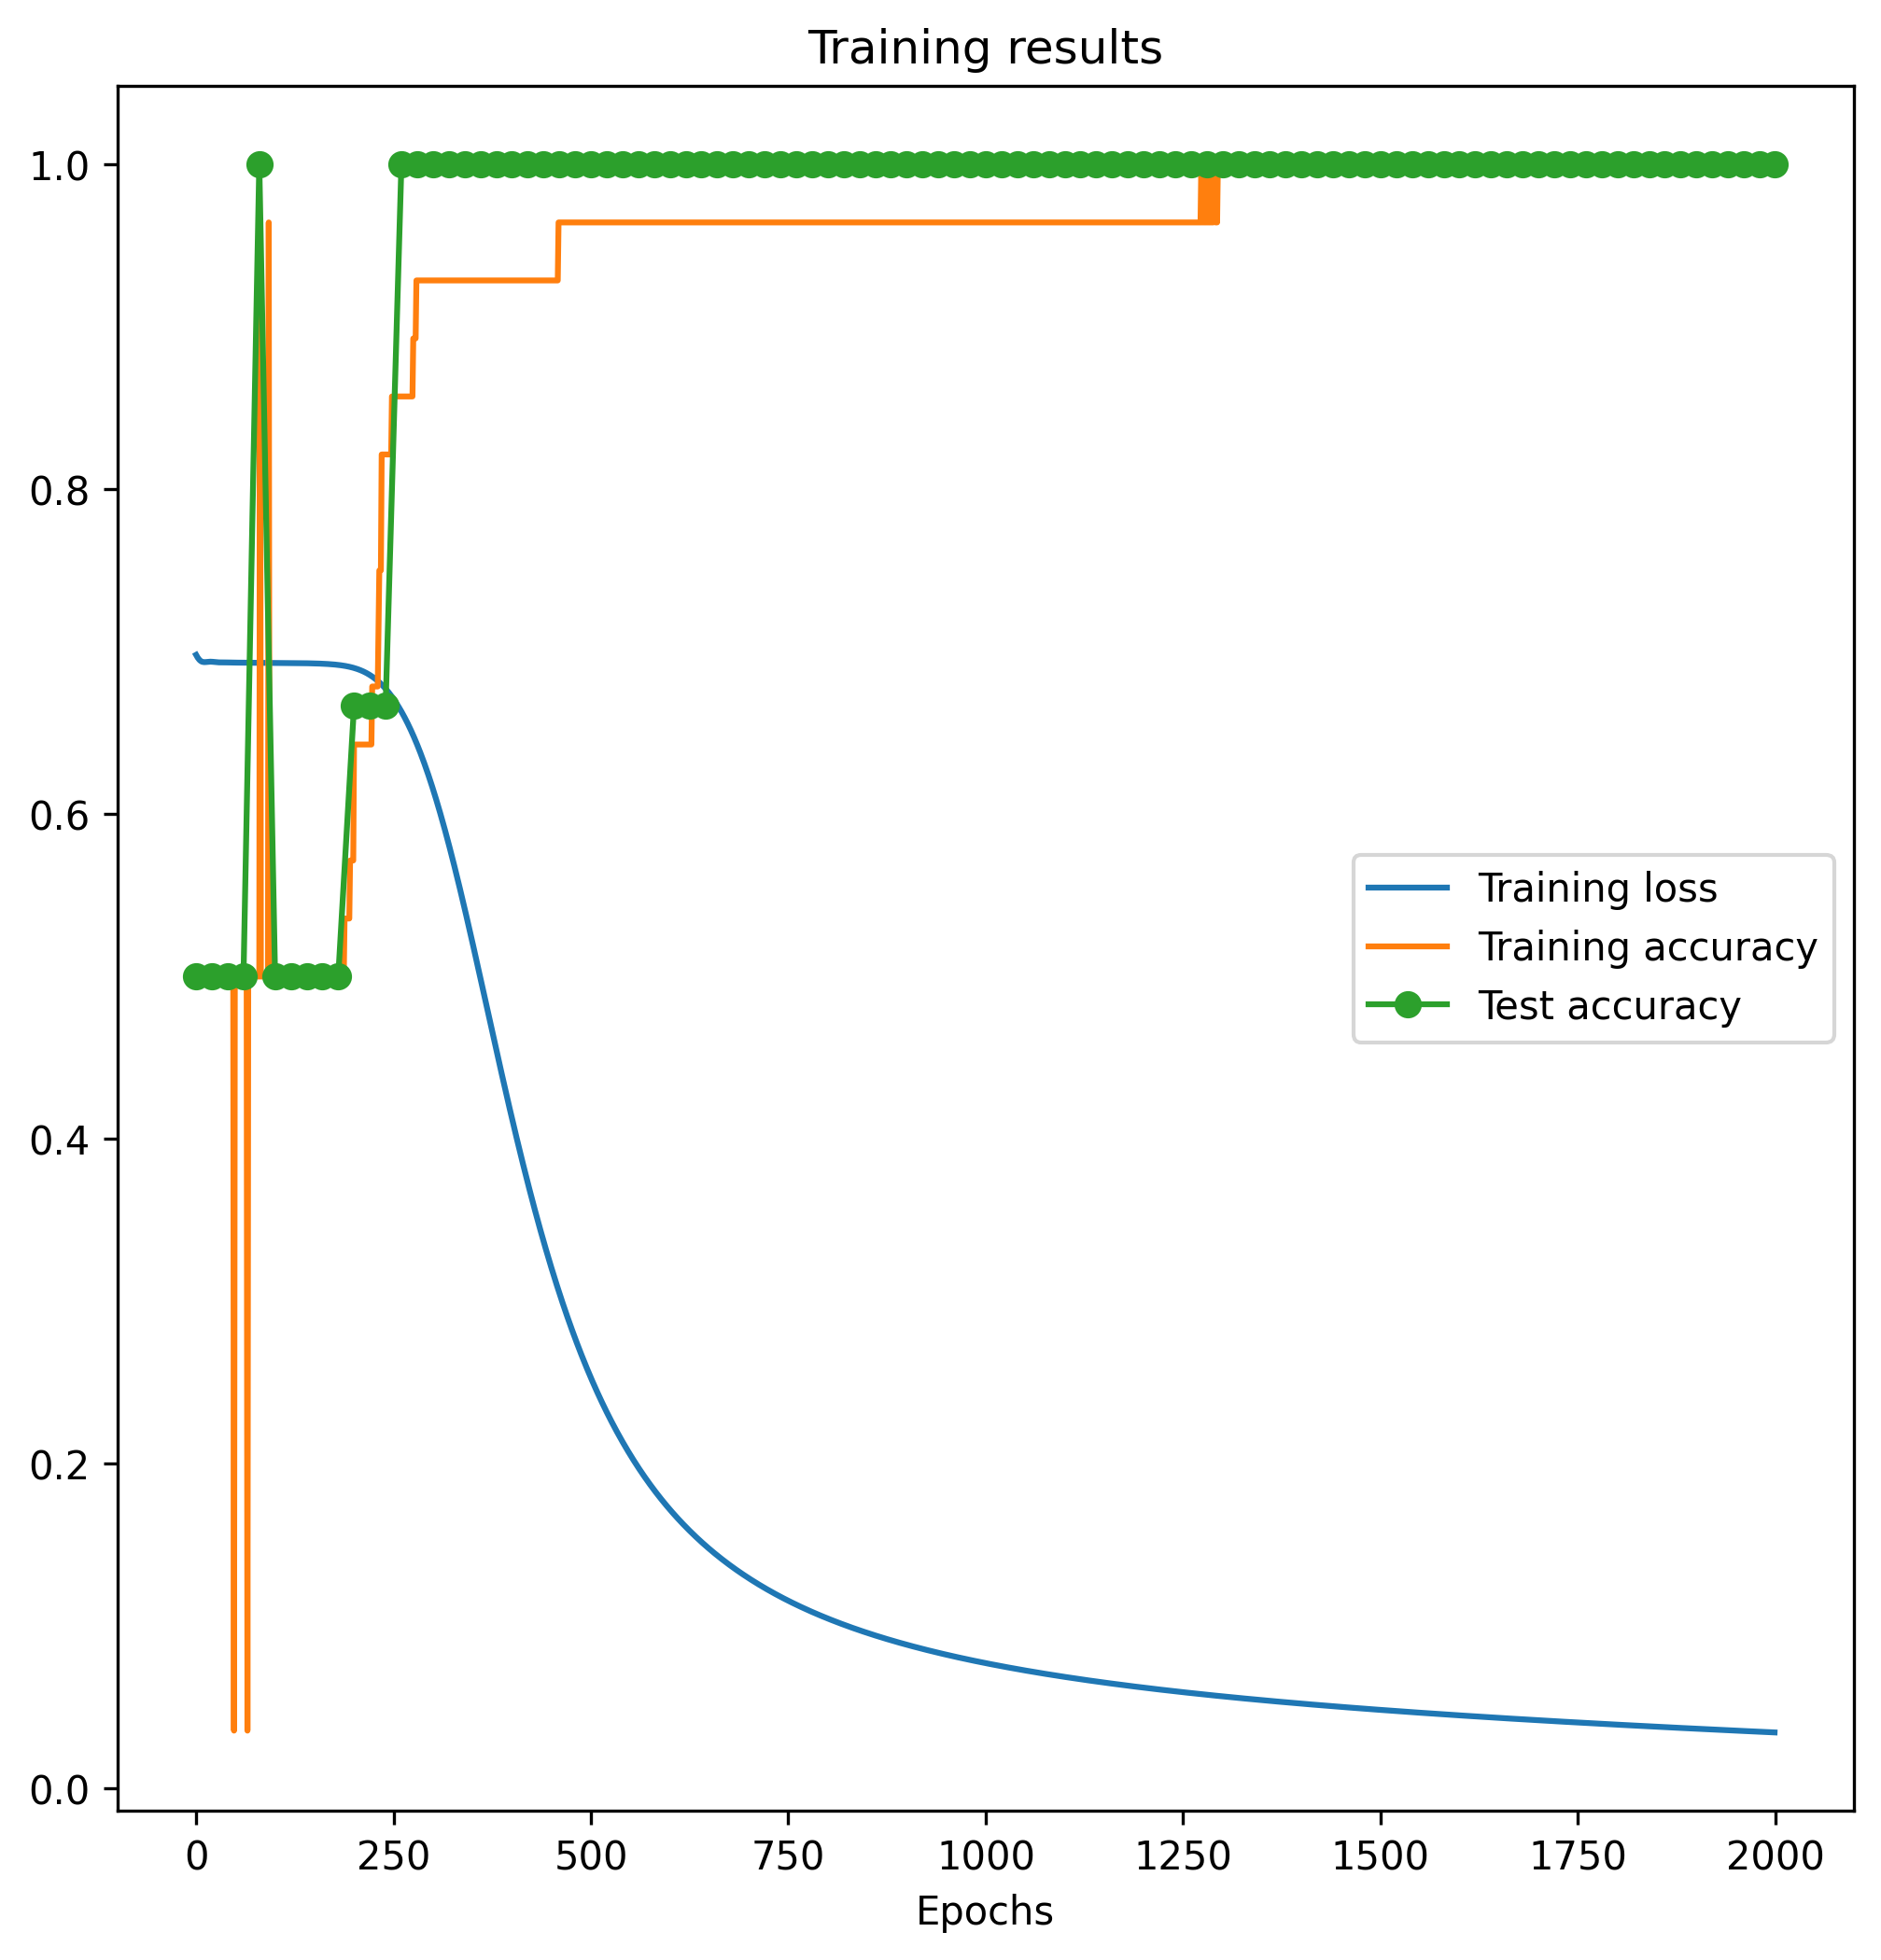

In [12]:
plt.figure(dpi=300)
plt.plot(losses, label="Training loss")
plt.plot(train_accs, label="Training accuracy")
test_epochs = np.isfinite(test_accs)
plt.plot(
    np.arange(num_epochs)[test_epochs],
    test_accs[test_epochs],
    label="Test accuracy",
    linestyle="-",
    marker="o",
)
plt.legend()
plt.xlabel("Epochs")
plt.title("Training results")